In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Loading Dataset

In [2]:
# Load dataset with supervised format (image, label)
(train_ds, val_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.B2D35M_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.B2D35M_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [3]:
print("Dataset Info:")
print(ds_info)

Dataset Info:
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/root/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemo

In [4]:
# Class names
class_names = ds_info.features['label'].names
print("Class Names:", class_names)

Class Names: ['rock', 'paper', 'scissors']


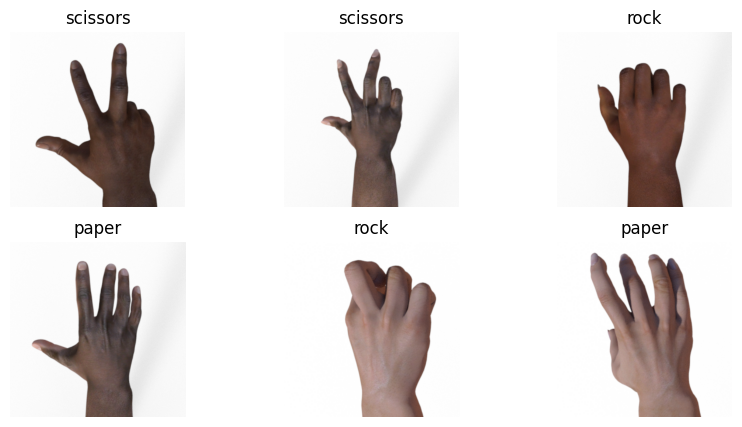

In [5]:
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [8]:
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # MobileNetV2-specific preprocessing
    return image, label

In [9]:
train_ds = train_ds.map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(format_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#Loading model

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [12]:
# Load the MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,         # We’ll add our own head
    weights='imagenet'         # Use pretrained ImageNet weights
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Add custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 193ms/step - accuracy: 0.8366 - loss: 0.4002 - val_accuracy: 1.0000 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9953 - loss: 0.0166 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9996 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 8.0284e-04 - learning_rate: 0.0010
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 7.1822e-04 - learning_rate: 0.0010
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 1.0000 - loss: 9.517

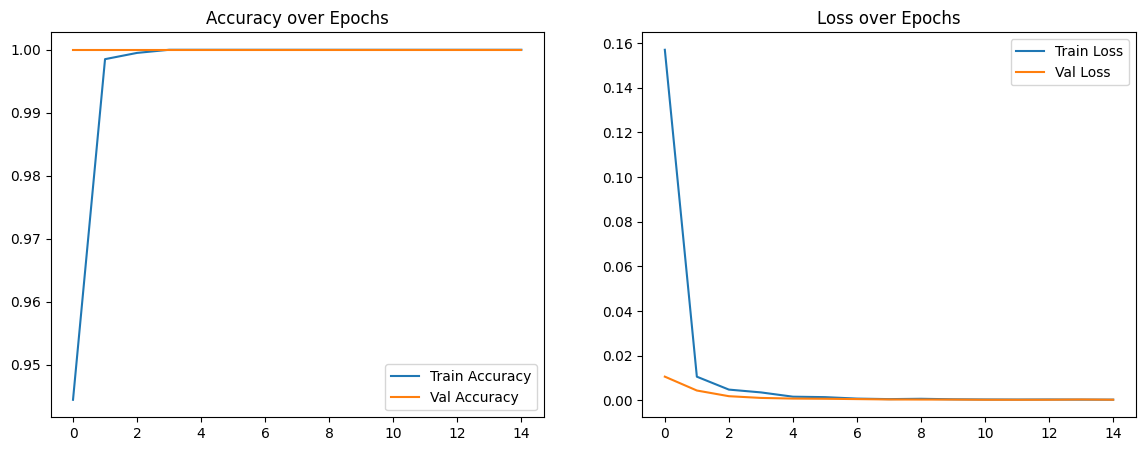

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_training_history(history)

In [19]:
# Unfreeze the top 20 layers of the base model
base_model.trainable = True

# Freeze all layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
fine_tune_epochs = 10

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.9328 - loss: 0.1753 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 1.0000e-05
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9966 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 8.7067e-04 - learning_rate: 1.0000e-05
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9997 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 6.9760e-04 - learning_rate: 1.0000e-05
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 1.0000e-05
Epoch 5/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9990 - loss: 0.0032
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 1.0000e-05
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0

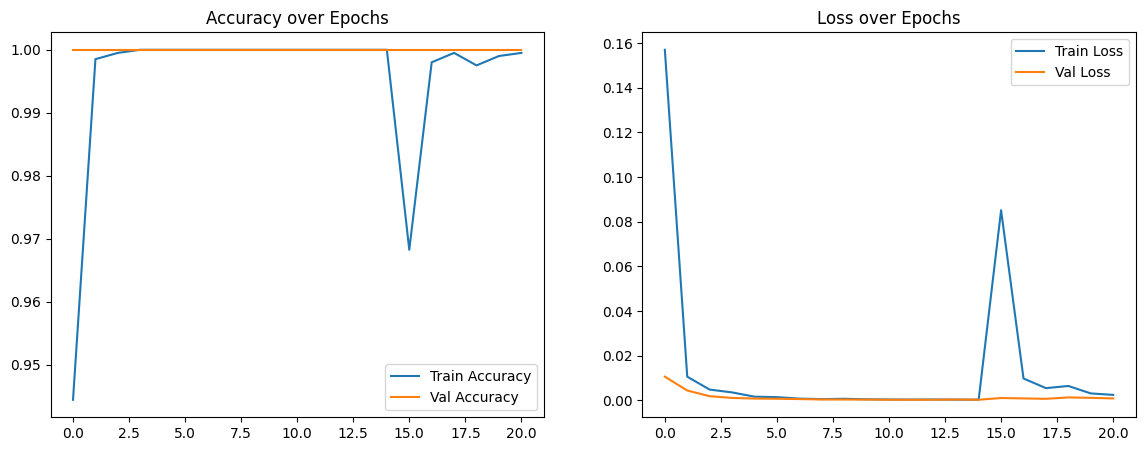

In [23]:
def plot_combined_history(initial, fine):
    acc = initial.history['accuracy'] + fine.history['accuracy']
    val_acc = initial.history['val_accuracy'] + fine.history['val_accuracy']
    loss = initial.history['loss'] + fine.history['loss']
    val_loss = initial.history['val_loss'] + fine.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

plot_combined_history(history, history_fine)


In [24]:
loss, accuracy = model.evaluate(val_ds)
print(f"✅ Final Validation Accuracy: {accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 0.0017
✅ Final Validation Accuracy: 100.00%


In [25]:
model.save("mobilenetv2_rps_classifier.h5")

Feature	MobileNetV2	ResNet50

Input Size	224x224	224x224

Parameters	~3.5M	~25M

Layers / Depth	88	177

ImageNet Top-1 Accuracy	~71.8%	~75.0%

Model Size	~14 MB	~98 MB

Inference Speed	Fast	Slower


MobileNetV2 was chosen for its small size and fast inference while maintaining good accuracy, making it ideal for small datasets and edge deployment.

#ResNet !!

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

In [27]:
def format_image_resnet(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = resnet_preprocess(image)  # ResNet-specific preprocessing
    return image, label

In [28]:
# Remap the dataset for ResNet50
train_ds_resnet = train_ds.unbatch().map(format_image_resnet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds_resnet = val_ds.unbatch().map(format_image_resnet).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [29]:
resnet_base = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
resnet_base.trainable = False  # Freeze the base

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [30]:
# Build model
resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])


In [31]:
# Compile
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
resnet_history = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
     63/Unknown 23s 96ms/step - accuracy: 0.7501 - loss: 0.5968

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.7520 - loss: 0.5931 - val_accuracy: 0.9821 - val_loss: 0.1241 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9806 - loss: 0.1064

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.9806 - loss: 0.1063 - val_accuracy: 0.9960 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 3/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9933 - loss: 0.0533

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9933 - loss: 0.0532 - val_accuracy: 0.9960 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 4/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9959 - loss: 0.0316

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.9959 - loss: 0.0316 - val_accuracy: 0.9960 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 5/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9992 - loss: 0.0192 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.9992 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 6/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9983 - loss: 0.0159

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 277ms/step - accuracy: 0.9983 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 7/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9987 - loss: 0.0110

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - accuracy: 0.9987 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 8/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0077

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 303ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 9/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9999 - loss: 0.0076

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.9999 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 10/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0067

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9980 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 11/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9983 - loss: 0.0062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9983 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 12/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0066

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 484ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 13/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0032

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 14/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0029

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 15/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0027

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 16/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0019

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 17/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.0019

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 18/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0018

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 19/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0014

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 20/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0019 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 21/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0013

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Epoch 22/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0017

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Epoch 23/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.0014

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 297ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 9.9806e-04 - learning_rate: 5.0000e-04
Epoch 24/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0010

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 298ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 9.8962e-04 - learning_rate: 5.0000e-04
Epoch 25/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 8.2443e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 1.0000 - loss: 8.2770e-04 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 5.0000e-04
Epoch 26/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 7.7624e-04 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 1.0000 - loss: 7.7728e-04 - val_accuracy: 1.0000 - val_loss: 8.9049e-04 - learning_rate: 2.5000e-04
Epoch 27/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 8.6378e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 1.0000 - loss: 8.6418e-04 - val_accuracy: 1.0000 - val_loss: 9.1816e-04 - learning_rate: 2.5000e-04
Epoch 28/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 8.8925e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 1.0000 - loss: 8.8888e-04 - val_accuracy: 1.0000 - val_loss: 8.9998e-04 - learning_rate: 2.5000e-04
Epoch 29/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 6.9438e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 1.0000 - loss: 6.9717e-04 - val_accuracy: 1.0000 - val_loss: 8.2802e-04 - learning_rate: 1.2500e-04
Epoch 30/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 7.7452e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 30: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step - accuracy: 1.0000 - loss: 7.7412e-04 - val_accuracy: 1.0000 - val_loss: 8.3061e-04 - learning_rate: 1.2500e-04
Restoring model weights from the end of the best epoch: 29.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [33]:
# Unfreeze top 20 layers of ResNet50
resnet_base.trainable = True
for layer in resnet_base.layers[:-20]:
    layer.trainable = False

In [34]:
# Recompile with low learning rate
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# Fine-tune
resnet_fine_history = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
     63/Unknown 29s 125ms/step - accuracy: 0.7927 - loss: 1.6803

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.7947 - loss: 1.6629 - val_accuracy: 0.9921 - val_loss: 0.0196 - learning_rate: 1.0000e-05
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0012

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9980 - val_loss: 0.0125 - learning_rate: 1.0000e-05
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9994 - loss: 0.0023

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 1.0000e-05
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 2.7629e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 1.0000 - loss: 2.7714e-04 - val_accuracy: 1.0000 - val_loss: 1.8546e-04 - learning_rate: 1.0000e-05
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.0235e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 295ms/step - accuracy: 1.0000 - loss: 6.0044e-04 - val_accuracy: 1.0000 - val_loss: 5.6855e-05 - learning_rate: 1.0000e-05
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.9077e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 1.0000 - loss: 3.9197e-04 - val_accuracy: 1.0000 - val_loss: 3.3471e-05 - learning_rate: 1.0000e-05
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 4.9587e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - accuracy: 1.0000 - loss: 4.9990e-04 - val_accuracy: 1.0000 - val_loss: 1.9904e-05 - learning_rate: 1.0000e-05
Epoch 8/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 2.0247e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 1.0000 - loss: 2.0280e-04 - val_accuracy: 1.0000 - val_loss: 1.6046e-05 - learning_rate: 5.0000e-06
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 1.3928e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - accuracy: 1.0000 - loss: 1.4030e-04 - val_accuracy: 1.0000 - val_loss: 1.4275e-05 - learning_rate: 5.0000e-06
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 8.1386e-05

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - accuracy: 1.0000 - loss: 8.1890e-05 - val_accuracy: 1.0000 - val_loss: 1.3945e-05 - learning_rate: 2.5000e-06
Restoring model weights from the end of the best epoch: 10.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [36]:
# Evaluate
resnet_loss, resnet_acc = resnet_model.evaluate(val_ds_resnet)
print(f"✅ ResNet50 Final Accuracy: {resnet_acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 1.0000 - loss: 1.7085e-05
✅ ResNet50 Final Accuracy: 100.00%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


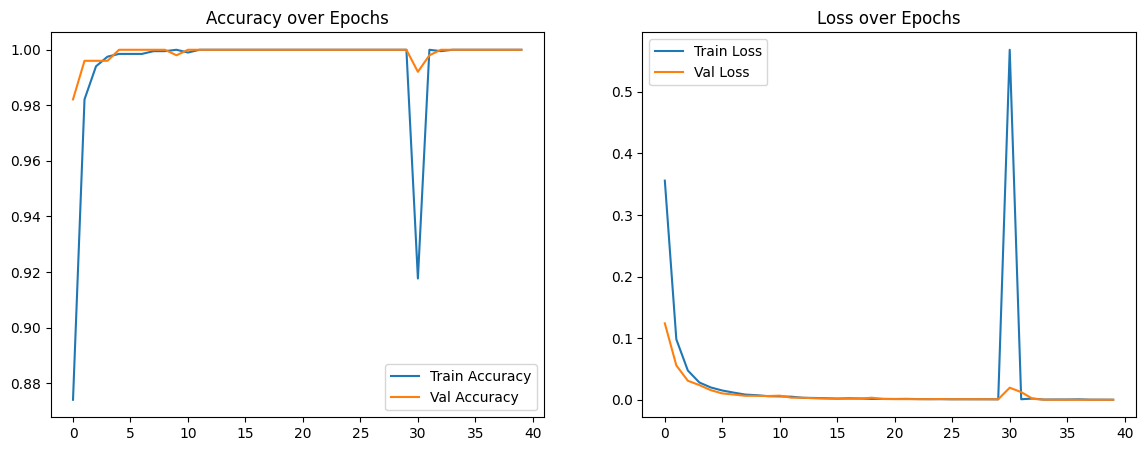

In [37]:
plot_combined_history(resnet_history, resnet_fine_history)

In [40]:
def visualize_predictions(model, dataset, class_names):
    import matplotlib.pyplot as plt
    import numpy as np

    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)

        plt.figure(figsize=(10, 10))
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            # Reverse preprocessing (MobileNetV2: [-1, 1] → [0, 255])
            img = (images[i].numpy() + 1.0) * 127.5
            img = np.clip(img, 0, 255).astype("uint8")

            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[pred_labels[i]]
            color = 'green' if pred_label == true_label else 'red'

            plt.imshow(img)
            plt.xlabel(f"True: {true_label}\nPred: {pred_label}", color=color)

        plt.tight_layout()
        plt.show()
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


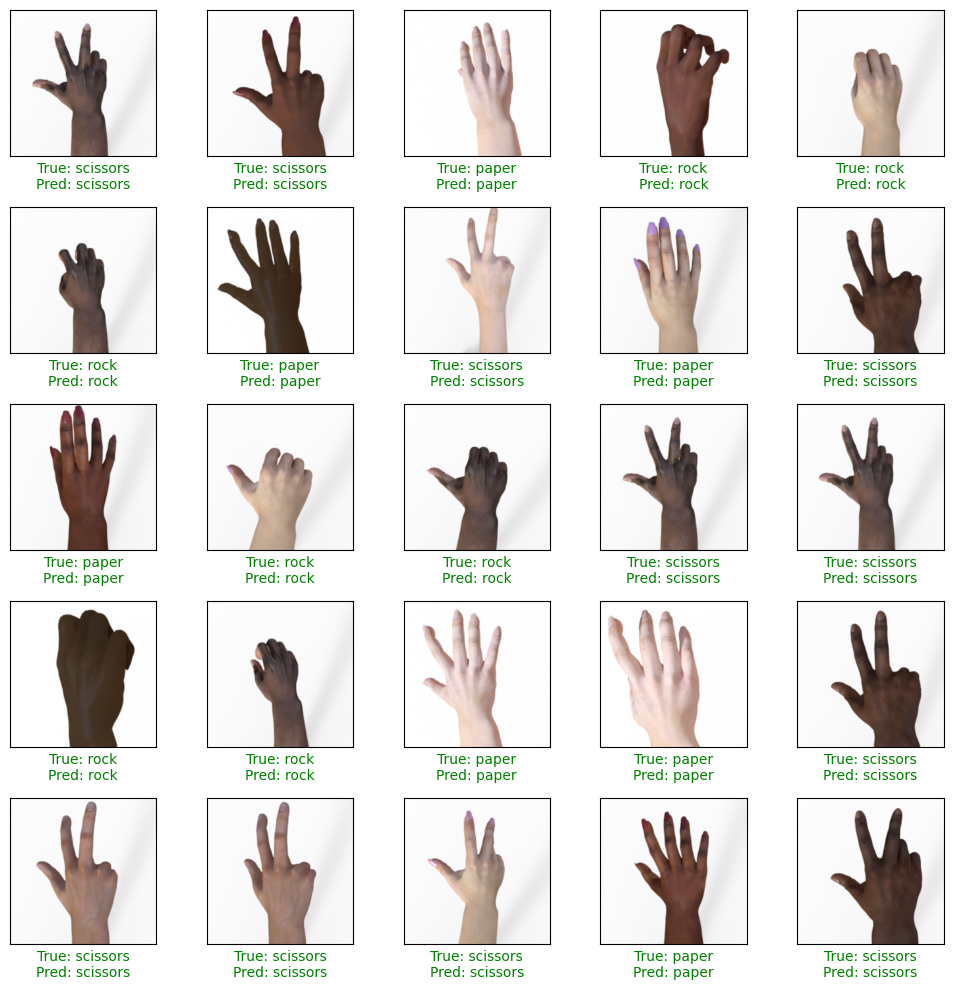

In [41]:
visualize_predictions(model, val_ds, class_names)

In [49]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
def plot_confusion_matrix(model, dataset, class_names, title="Confusion Matrix"):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        preds = model.predict(images)
        pred_classes = np.argmax(preds, axis=1)

        true_labels.extend(labels.numpy())
        pred_labels.extend(pred_classes)

    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


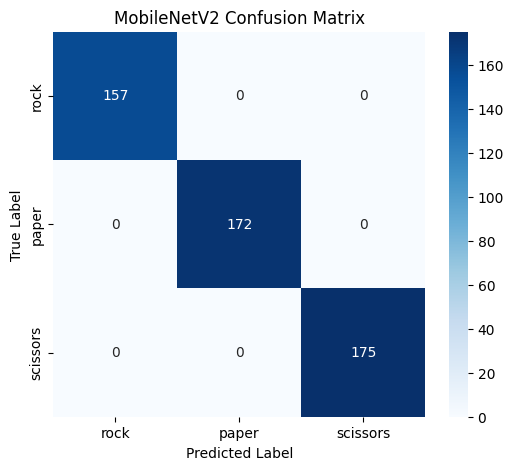

In [51]:
# For MobileNetV2
plot_confusion_matrix(model, val_ds, class_names, title="MobileNetV2 Confusion Matrix")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


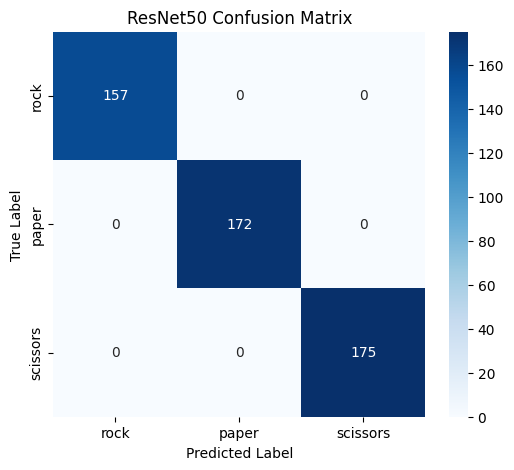

In [52]:
# For ResNet50
plot_confusion_matrix(resnet_model, val_ds_resnet, class_names, title="ResNet50 Confusion Matrix")

Which performed better?

Both performed very well ....
• Any noticeable difference in training speed?

yes , mobileNEtV2's training time << ResNet50